In [1]:
from astropy.io import ascii 
from astropy.table import Table
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
# from astropy.cosmology import WMAP9 as cosmo
from astropy.modeling import models, fitting
import os
import pickle
from scipy.optimize import curve_fit
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [2]:
#total catalog from COSMOS(2016)
total = Table.read('./datas/cosmos2015_2.fits')

#mass complete sample
total_z = total[(total['zphot'] > 0) & (total['zphot'] < 9) & (total['OType'] == 0) & (total['Mass'] > 9.545)]

In [3]:
total_pd = total_z.to_pandas()

In [4]:

#find grid step: 100kpc
def find_grid_step(z):
    sep = cosmo.arcsec_per_kpc_proper(z) * 100 * u.kpc
    return sep.to(u.deg).value

#find bin size
def find_bin_size(z):
    del_z = 0.015 * (1+z)
    return del_z

#find search radius: 700kpc
def find_search_radius(z):
    r = cosmo.arcsec_per_kpc_proper(z) * 700 * u.kpc # arcsec
    
    return r.to(u.deg).value

#find redshift increment next to z
def find_bin_step(z):
    closest = 0
    compare_v = 100
    
    for i in np.arange(z+0.03, z, -0.00001):
        v = cosmo.H0 * (cosmo.comoving_distance(i) - cosmo.comoving_distance(z)) 
#         
        if np.abs(v.value - 1500) < compare_v:
            closest = i
            compare_v = np.abs(v.value - 1500)
#             print(compare_v, end = ' ')
    #return next z
    return closest



In [5]:

redshifts = np.load('bins/bins_cosmos/search_700kpc/redshifts/redshifts.npy')
binsize = np.load('bins/bins_cosmos/search_700kpc/redshifts/binsize.npy')

In [6]:
#xray 2018
x_new = ascii.read('./datas/xray_2018.txt')
bellagamba = Table.read('./datas/bellagamba2011')
bellagamba = bellagamba.to_pandas()

In [7]:
# hasinger = Table.read('./datas/Hasinger_10k_spec_z')
hasinger = Table.read('./datas/Hasinger_crossmatch')

In [8]:
file_list = os.listdir(f'./bins/bins_cosmos/search_700kpc/')
file_list.sort()

mask1_list = os.listdir(f'./bins/bins_cosmos/search_700kpc/mask1_10/')
mask2_list = os.listdir(f'./bins/bins_cosmos/search_700kpc/mask2_10/')
mask1_list.sort()
mask2_list.sort()

xlist = os.listdir('./bins/bins_cosmos/search_700kpc/grid_x/')
ylist = os.listdir('./bins/bins_cosmos/search_700kpc/grid_y/')

xlist.sort()
ylist.sort()

In [9]:
od = 4
#save index of overdense region
with open(f'./datas/index1_od{od}.txt', 'rb') as f:
    index1 = pickle.load(f)

with open(f'./datas/index2_od{od}.txt', 'rb') as f:
    index2 = pickle.load(f)

with open(f'./datas/od{od}_ra.txt', 'rb') as f:
    od_ra = pickle.load(f)

with open(f'./datas/od{od}_dec.txt', 'rb') as f:
    od_dec = pickle.load(f)

with open(f'./datas/z_idx_od{od}.txt', 'rb') as f:
    z_idx = pickle.load(f)

In [11]:
#save index of overdense region
with open(f'./candidates/ras1.txt', 'rb') as f:
    ras = pickle.load(f)

with open(f'./candidates/decs1.txt', 'rb') as f:
    decs = pickle.load(f)

with open(f'./candidates/zs1.txt', 'rb') as f:
    zs = pickle.load(f)
    
with open(f'./candidates/members1.txt', 'rb') as f:
    members = pickle.load(f)


In [14]:
def find_radius(z, r):
    r = cosmo.arcsec_per_kpc_proper(z) * r * u.Mpc # arcsec
    
    return r.to(u.deg).value

/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


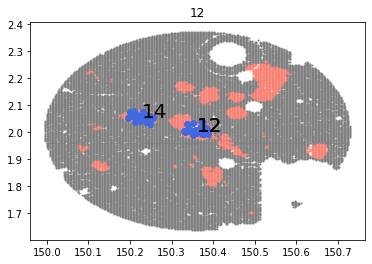

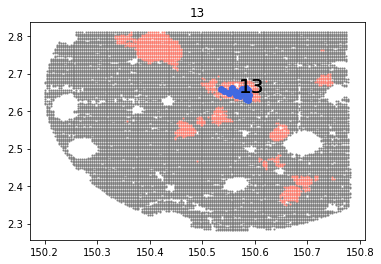

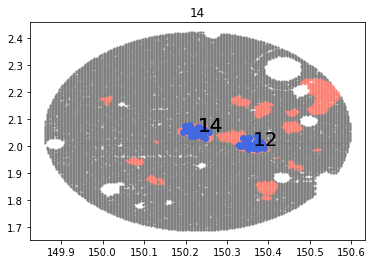

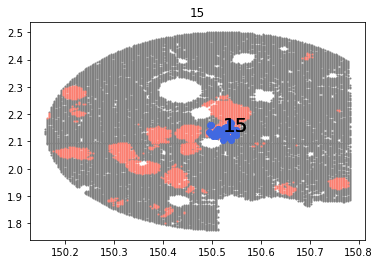

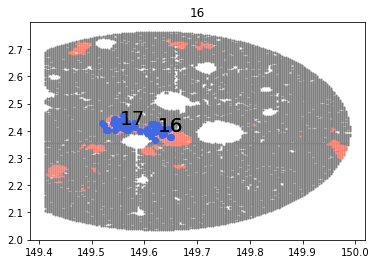

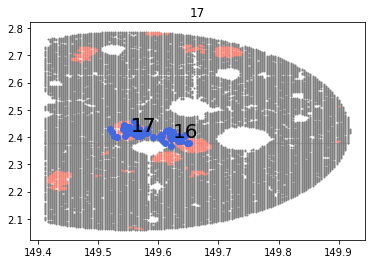

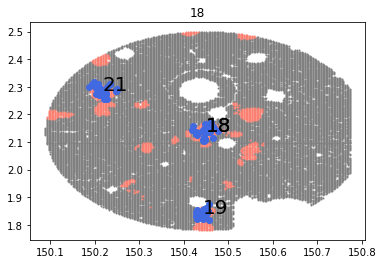

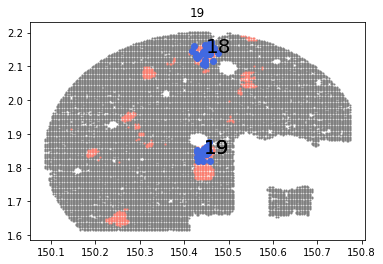

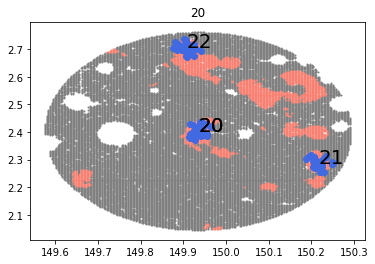

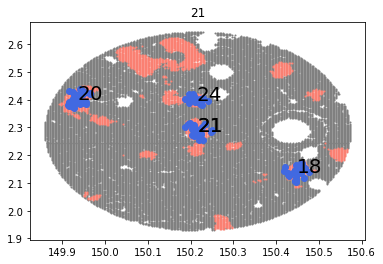

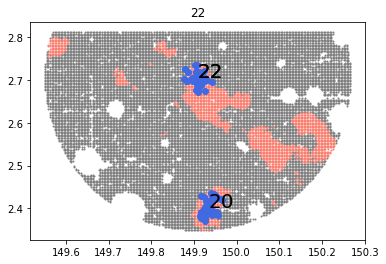

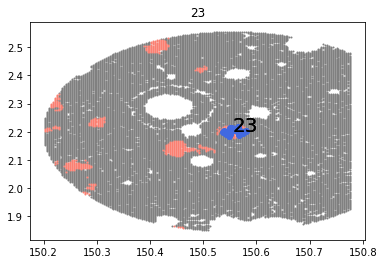

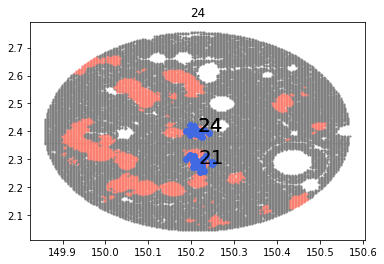

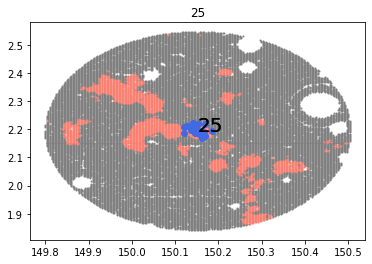

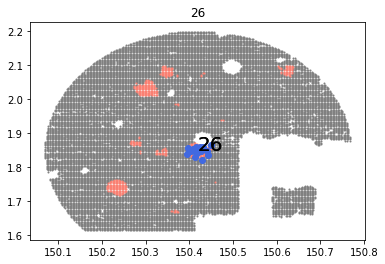

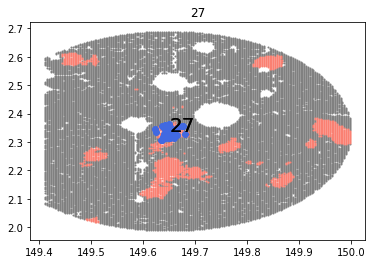

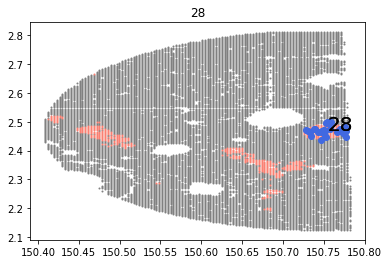

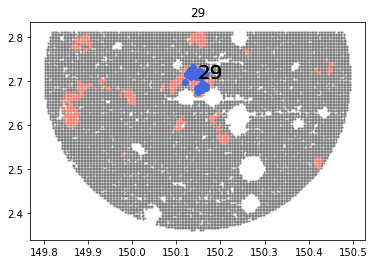

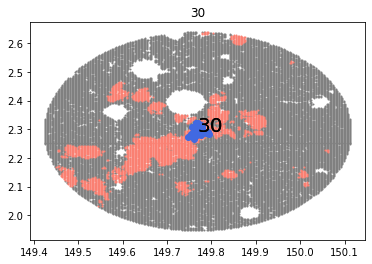

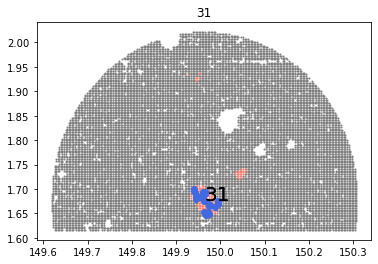

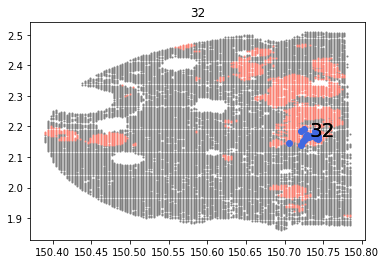

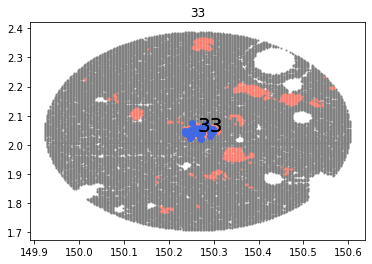

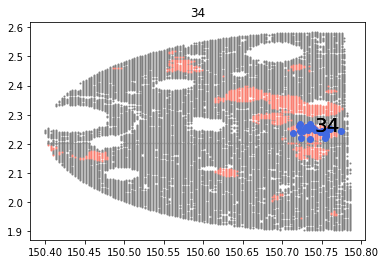

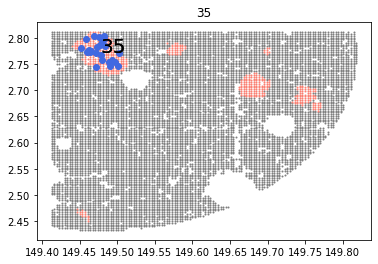

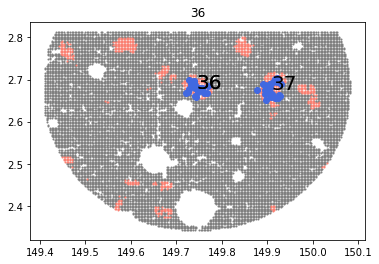

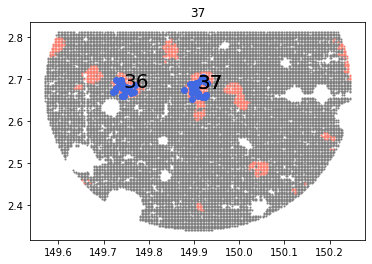

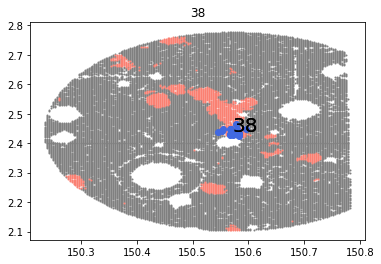

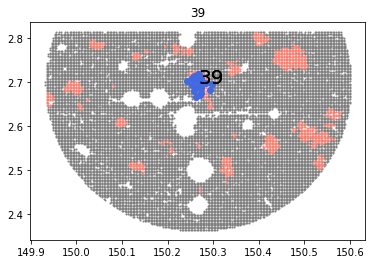

In [16]:
for i in range(12, len(members)):
    
#     smask = total_pd['Seq'].isin(members[i])
#     samp = total_pd[smask]
    
    z_index = np.argmin((redshifts - zs[i])**2) 
    grid = np.load('./bins/bins_cosmos/search_700kpc/' + file_list[z_index])
    mask1 = np.load('./bins/bins_cosmos/search_700kpc/mask1_10/' + mask1_list[z_index])
    mask2 = np.load('./bins/bins_cosmos/search_700kpc/mask2_10/' + mask2_list[z_index])

    grid_x = np.load('./bins/bins_cosmos/search_700kpc/grid_x/' + xlist[z_index])
    grid_y = np.load('./bins/bins_cosmos/search_700kpc/grid_y/' + ylist[z_index])
    
    grid_1d = grid[mask1 & mask2]

    mean = grid_1d.mean()
    std = grid_1d.std()

    overdense_mask2 = grid > mean + 2 * std
    sparse_mask2 = grid < mean + 2 * std
    
    grid_od = (grid - mean) / std

    search = find_radius(zs[i], 10)
    area_mask = ((grid_x - ras[i])**2 + (grid_y - decs[i])**2 < search**2)
    
    plt.figure()
    plt.scatter(grid_x[mask1 & mask2 & area_mask&sparse_mask2], grid_y[mask1 & mask2 & area_mask& sparse_mask2], color = 'grey', s = 1)
    plt.scatter(grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask& overdense_mask2], color = 'salmon', s = 1)
    
    plt.title(f'{i}')
    
    plt.text(ras[i], decs[i], f'{i}', fontsize = 20)
    for j in range(12, len(members)):
        smask = total_pd['Seq'].isin(members[j])
        samp = total_pd[smask]
        
        dist_mask = (ras[j] - ras[i])**2 + (decs[j] - decs[i])**2 < search**2
        z_mask = (zs[j] > zs[i] - 0.02) & (zs[j] < zs[i] + 0.02)
        
        if dist_mask and z_mask:
            plt.scatter(samp['RAJ2000'], samp['DEJ2000'], color = 'royalblue')
            plt.text(ras[j], decs[j], f'{j}', fontsize = 20)
            
#     plt.savefig(f'{i}.png')

# Multi-structure

## OD12, OD14 - two nearby clusters

In [17]:
mem12_mask = total_pd['Seq'].isin(members[12])
mem12 = total_pd[mem12_mask]

mem14_mask = total_pd['Seq'].isin(members[14])
mem14 = total_pd[mem14_mask]

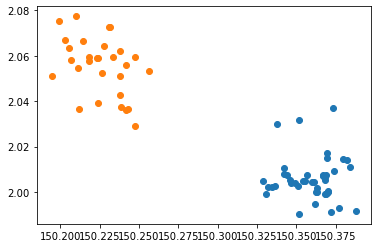

In [20]:
plt.scatter(mem12['RAJ2000'], mem12['DEJ2000'])
plt.scatter(mem14['RAJ2000'], mem14['DEJ2000'])

## OD16, OD17 - two nearby clusters

In [22]:
mem16_mask = total_pd['Seq'].isin(members[16])
mem16 = total_pd[mem16_mask]

mem17_mask = total_pd['Seq'].isin(members[17])
mem17 = total_pd[mem17_mask]

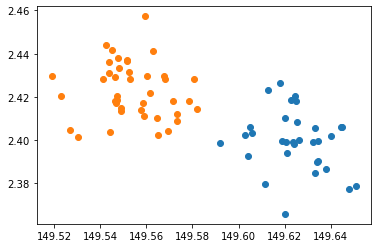

In [24]:
plt.scatter(mem16['RAJ2000'], mem16['DEJ2000'])
plt.scatter(mem17['RAJ2000'], mem17['DEJ2000'])

## OD21, OD24

In [25]:
mem21_mask = total_pd['Seq'].isin(members[21])
mem21 = total_pd[mem21_mask]

mem24_mask = total_pd['Seq'].isin(members[24])
mem24 = total_pd[mem24_mask]

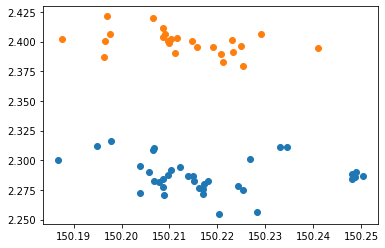

In [26]:
plt.scatter(mem21['RAJ2000'], mem21['DEJ2000'])
plt.scatter(mem24['RAJ2000'], mem24['DEJ2000'])

# Structures

0.6360509554140129
0.5032484076433121
0.2612101910828025
0.3000000000000001
0.6118152866242038
0.4098726114649682
0.9130891719745227
0.836687898089172
0.8172292993630573
0.5581210191082803
0.32254777070063695
0.5626114649681528
0.7835987261146494
0.5198726114649683
0.8585031847133758
0.7027070063694267
0.735
0.6284076433121016
0.8100955414012736
0.6254458598726113


/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


0.7978662420382169
0.8124203821656049
0.5228343949044584
0.737738853503185
0.7782484076433122
0.8124840764331207
0.6642675159235667
0.7374522292993628
0.4585350318471339
0.5823566878980891
0.7848726114649685
0.5536942675159235
0.4229299363057325
0.8570063694267516
0.45
0.28961783439490435
0.6120063694267514
0.6087898089171975
0.6958917197452231
0.5906687898089172


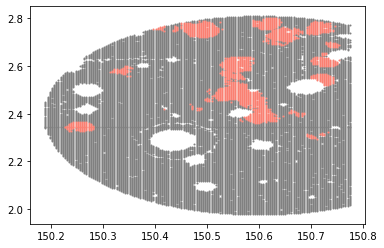

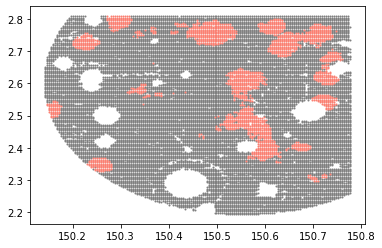

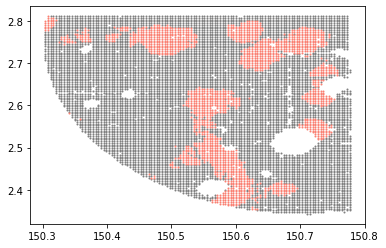

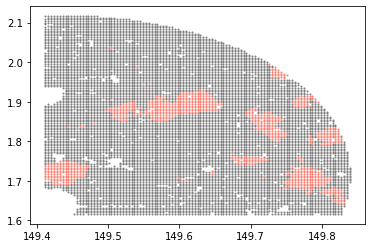

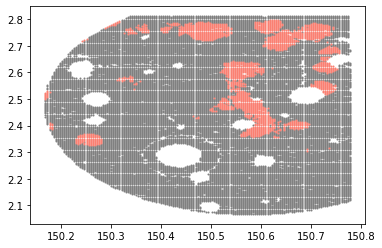

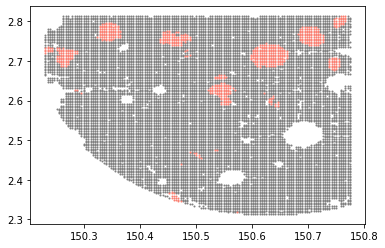

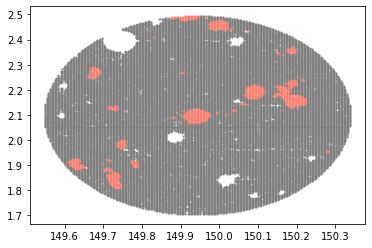

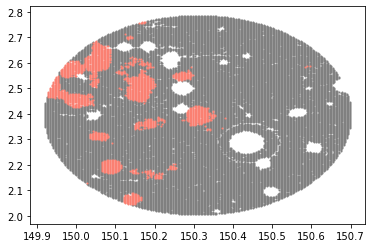

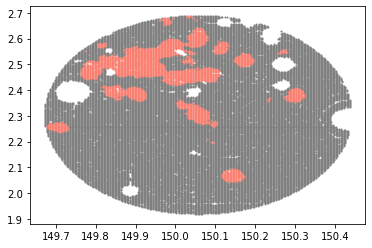

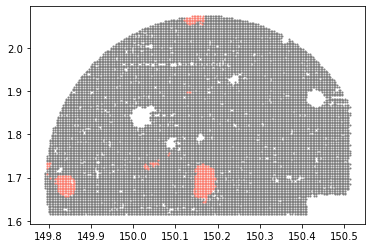

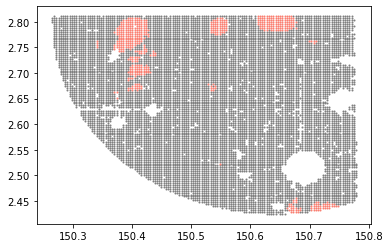

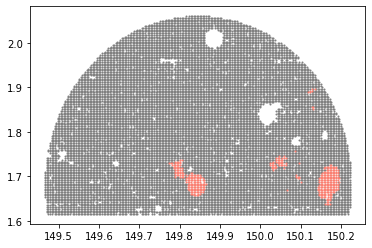

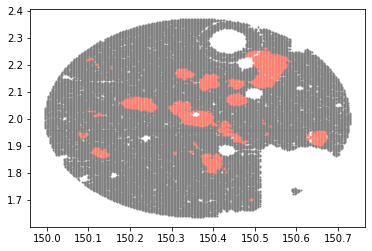

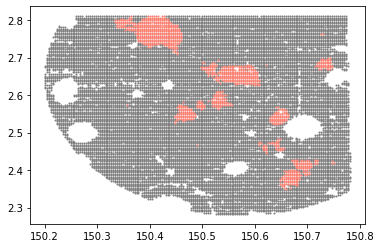

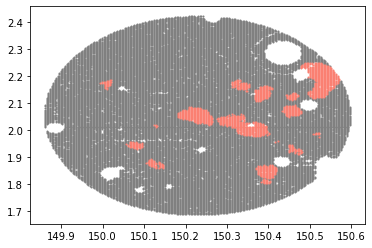

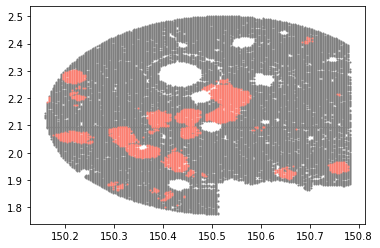

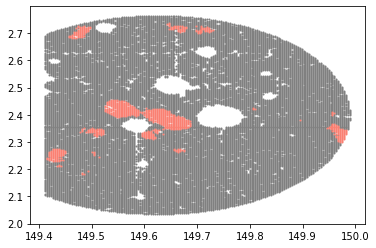

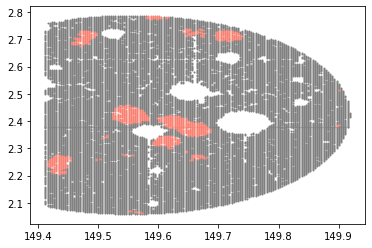

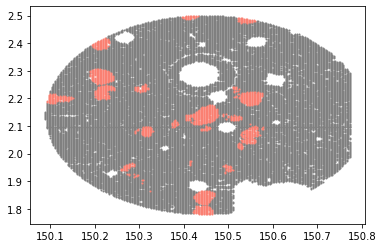

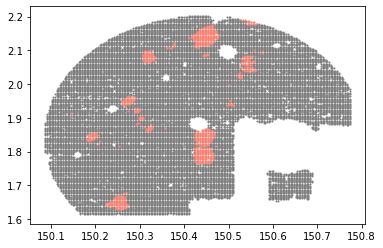

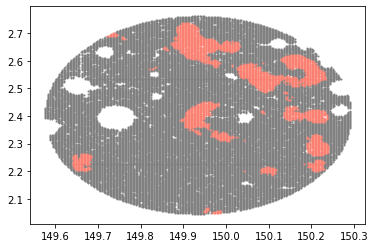

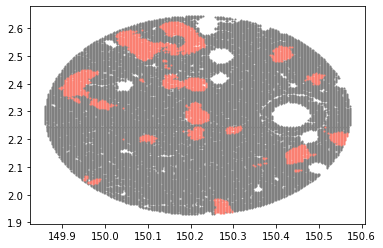

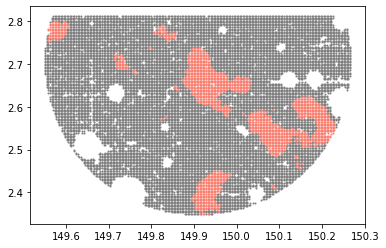

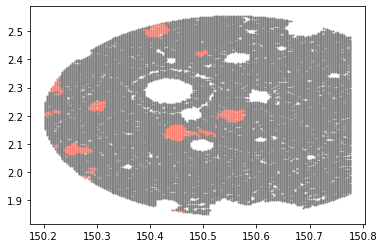

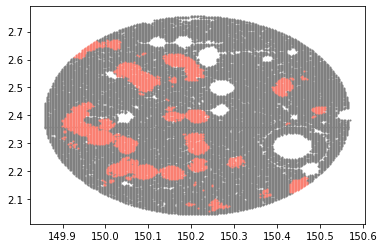

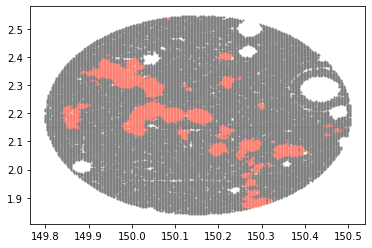

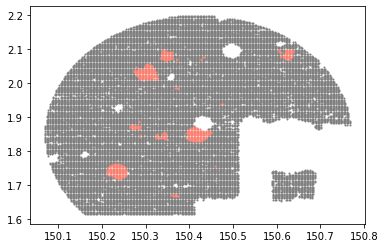

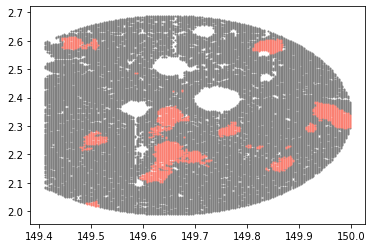

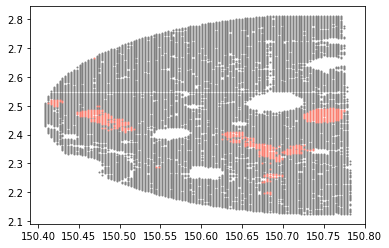

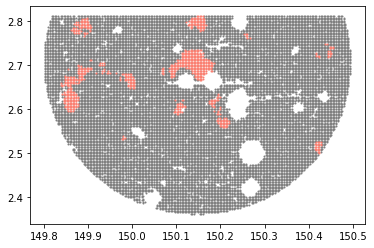

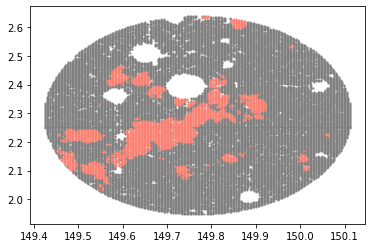

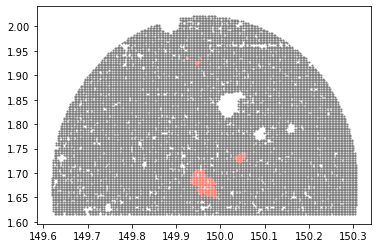

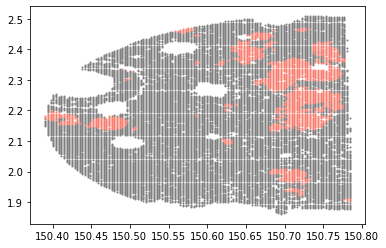

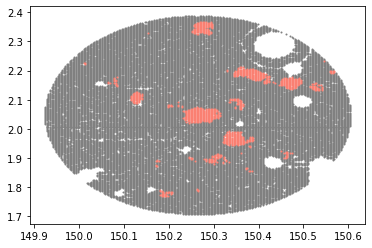

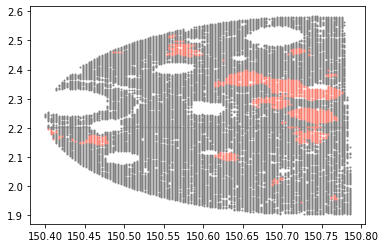

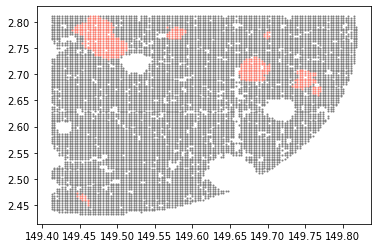

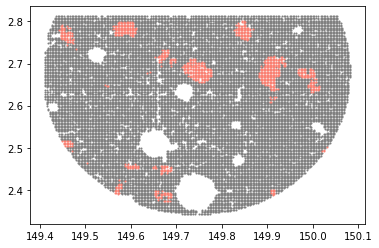

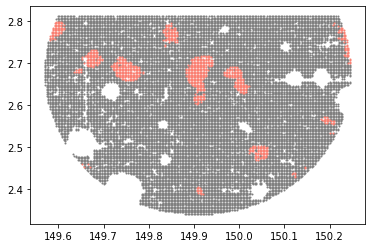

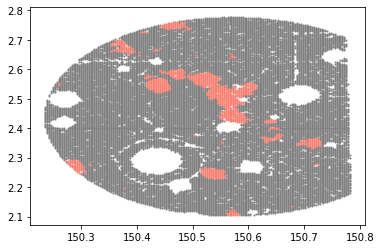

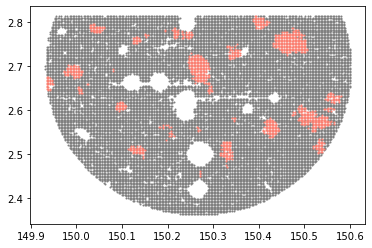

In [27]:
areas = []
for i in range(len(members)):
    
#     smask = total_pd['Seq'].isin(members[i])
#     samp = total_pd[smask]
    
    z_index = np.argmin((redshifts - zs[i])**2) 
    grid = np.load('./bins/bins_cosmos/search_700kpc/' + file_list[z_index])
    mask1 = np.load('./bins/bins_cosmos/search_700kpc/mask1_10/' + mask1_list[z_index])
    mask2 = np.load('./bins/bins_cosmos/search_700kpc/mask2_10/' + mask2_list[z_index])

    grid_x = np.load('./bins/bins_cosmos/search_700kpc/grid_x/' + xlist[z_index])
    grid_y = np.load('./bins/bins_cosmos/search_700kpc/grid_y/' + ylist[z_index])
    
    grid_1d = grid[mask1 & mask2]

    mean = grid_1d.mean()
    std = grid_1d.std()

    overdense_mask2 = grid > mean + 2 * std
    sparse_mask2 = grid < mean + 2 * std
    
    grid_od = (grid - mean) / std

    search = find_radius(zs[i], 10)
    area_mask = ((grid_x - ras[i])**2 + (grid_y - decs[i])**2 < search**2)
    
    plt.figure()
    plt.scatter(grid_x[mask1 & mask2 & area_mask&sparse_mask2], grid_y[mask1 & mask2 & area_mask& sparse_mask2], color = 'grey', s = 1)
    plt.scatter(grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask& overdense_mask2], color = 'salmon', s = 1)
    
    
    gstep = find_grid_step(zs[i])
    
    num = (search / gstep)**2 * 3.14
    print(len(grid_x[mask1 & mask2 & area_mask&sparse_mask2]) / num)
    
    areas.append(len(grid_x[mask1 & mask2 & area_mask&sparse_mask2]) / num)
areas = np.array(areas)

In [132]:
cands = np.where(areas > 0.5)[0]
cands = cands[cands >= 12]

In [133]:
def find_fofs(cra, cdec, fof_ra, fof_dec, z_index, ll):
    
    check = np.full(fof_ra.shape, True, dtype = bool) #index
    print(f'total {len(fof_ra)} grid points')
    #2Mpc
    gstep = find_radius(redshifts[z_index], ll)

    f1mask = (cra - fof_ra)**2 + (cdec - fof_dec)**2 <= gstep**2
    f1_index = list(np.where(f1mask)[0])
    
    check[f1mask] = False
    
    if len(f1_index) == 0:
        print('no first friend found')
        return 
    
    new_index = []
    
    temp_index = []
    
    first = True
    while True:
        if first:
            first = False
            cand_index = f1_index.copy()
        else:
            cand_index = temp_index.copy()
            temp_index = []
            
#         print(len(cand_index))
#         print(cand_index)
        for j in range(len(cand_index)):
            f2mask = (fof_ra[cand_index[j]] - fof_ra)**2 + (fof_dec[cand_index[j]] - fof_dec)**2 < gstep**2
            f2_index = np.where(f2mask & check)[0]
            
            check[f2_index] = False
            
            if len(f2_index)  == 0:
                continue
                
            temp_index.extend(list(f2_index))
        new_index.extend(temp_index)
        if len(temp_index) == 0:
            break
#     print(new_index)
    f1_index.extend(new_index)
    final_index = f1_index
    return final_index

In [134]:
def cal_fqs(candidates):
    fqs = []
    
    for i in candidates:

        smask = total_pd['Seq'].isin(members[i])
        samp = total_pd[smask]

        age = cosmo.age(zs[i]).to(u.yr).value
        ssfr_mask  = 10**total_pd['sSFR'] < 1 / 3 / age

        ssfr = samp[ssfr_mask]

        fq = len(ssfr) / len(samp)
        fqs.append(fq)
    return fqs 

In [135]:
def cal_fofs(candidates):

    fofs = []
    for i in candidates:


        z_index = np.argmin((redshifts - zs[i])**2) 
        grid = np.load('./bins/bins_cosmos/search_700kpc/' + file_list[z_index])
        mask1 = np.load('./bins/bins_cosmos/search_700kpc/mask1_10/' + mask1_list[z_index])
        mask2 = np.load('./bins/bins_cosmos/search_700kpc/mask2_10/' + mask2_list[z_index])

        grid_x = np.load('./bins/bins_cosmos/search_700kpc/grid_x/' + xlist[z_index])
        grid_y = np.load('./bins/bins_cosmos/search_700kpc/grid_y/' + ylist[z_index])

        grid_1d = grid[mask1 & mask2]

        mean = grid_1d.mean()
        std = grid_1d.std()

        overdense_mask2 = grid > mean + 2 * std
        sparse_mask2 = grid < mean + 2 * std

        grid_od = (grid - mean) / std

        search = find_radius(zs[i], 10)
        area_mask = ((grid_x - ras[i])**2 + (grid_y - decs[i])**2 < search**2)

        plt.figure()
        plt.scatter(grid_x[mask1 & mask2 & area_mask&sparse_mask2], grid_y[mask1 & mask2 & area_mask& sparse_mask2], color = 'grey', s = 1)
        plt.scatter(grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask& overdense_mask2], color = 'salmon', s = 1)

        plt.title(f'{i}')

        findex = find_fofs(ras[i], decs[i], grid_x[mask1 & mask2 & area_mask&overdense_mask2], grid_y[mask1 & mask2 & area_mask&overdense_mask2], z_index, 1)    


        fof = len(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex]) / len(grid_x[mask1 & mask2 & area_mask])
        plt.scatter(grid_x[mask1 & mask2 & area_mask & overdense_mask2][findex], grid_y[mask1 & mask2 & area_mask & overdense_mask2][findex], color = 'firebrick', alpha = 1, s = 1)

        fofs.append(fof)
        
    return fofs

In [193]:
def cal_cons(candidates):
    concent = []
    
    for i in candidates:
        
        smask = total_pd['Seq'].isin(members[i])
        samp = total_pd[smask]

        ra = ras[i]
        dec = decs[i]

        dist = (samp['RAJ2000'] - ra)**2 + (samp['DEJ2000'] - dec)**2
        dist = dist.values

        dist_idx = np.argsort(dist)


        idx3 = dist_idx[int(len(dist) * 0.3)]
        idx7 = dist_idx[int(len(dist) * 0.7)]

        area3 = dist[idx3]
        area7 = dist[idx7]

        conp = area3/area7

#         fig, ax = plt.subplots()
#         ax.scatter(samp['RAJ2000'], samp['DEJ2000'])
#         ax.scatter(ra, dec)

#         circ1 = plt.Circle((ra, dec), np.sqrt(area3), fill = False)
#         ax.add_patch(circ1)
# 
#         circ2 = plt.Circle((ra, dec), np.sqrt(area7), fill = False)
#         ax.add_patch(circ2)
        concent.append(conp)
    return concent

In [194]:
# fofs = cal_fofs(cands)
# fqs = cal_fqs(cands)
conps = cal_cons(cands)

-0.2256930583844316


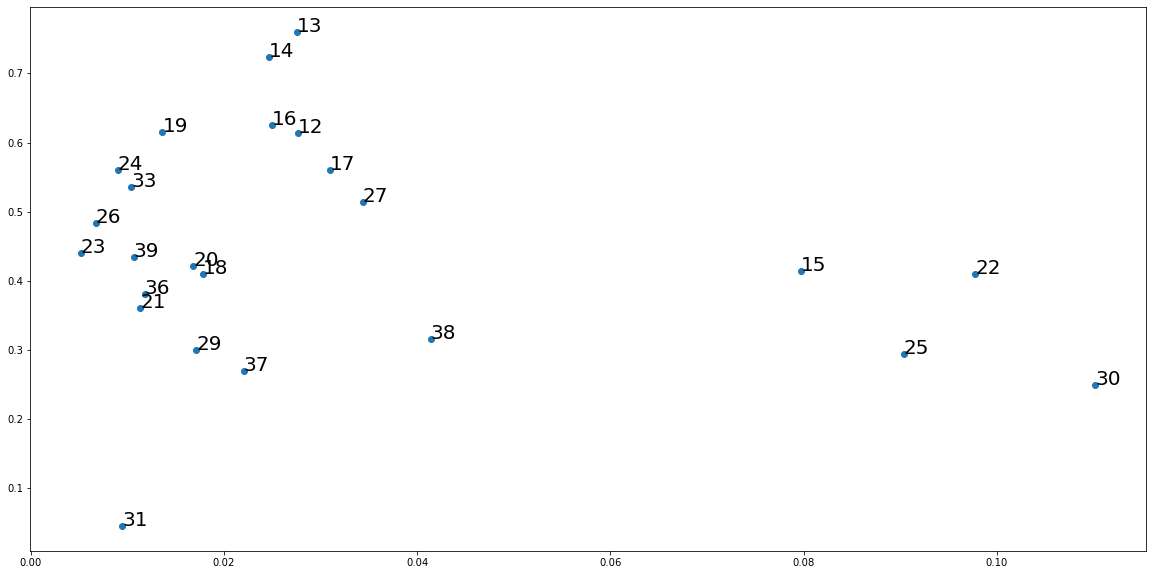

In [195]:
plt.figure(figsize = (20, 10))
plt.scatter(fofs, fqs)

for i in range(len(cands)):
    plt.text(fofs[i], fqs[i], f'{cands[i]}', fontsize = 20)

print(np.corrcoef(fofs, fqs)[0, 1])



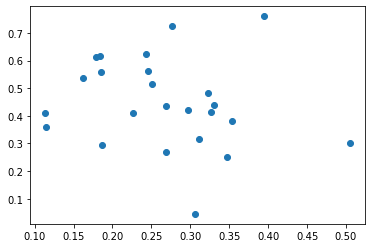

In [197]:
plt.scatter(conps, fqs)

In [199]:
np.corrcoef(conps, fqs[0, 1])

TypeError: list indices must be integers or slices, not tuple

In [138]:
cands2 = [x for x in cands if x not in [12, 14, 16, 17, 21, 24]]

total 1364 grid points
total 2438 grid points
total 1612 grid points
total 916 grid points
total 3230 grid points
total 2491 grid points
total 707 grid points
total 2964 grid points
total 617 grid points
total 1941 grid points
total 952 grid points
total 3370 grid points
total 201 grid points
total 1212 grid points
total 1045 grid points
total 1107 grid points
total 1444 grid points
total 1379 grid points


/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/home/ehko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed 

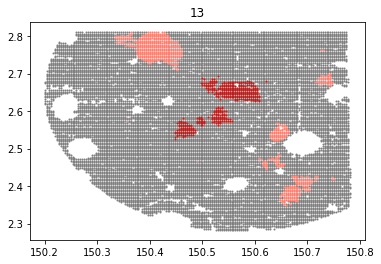

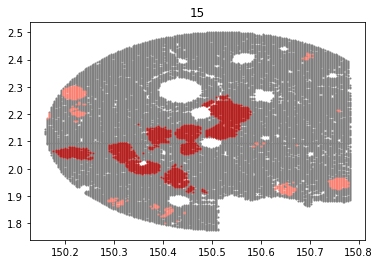

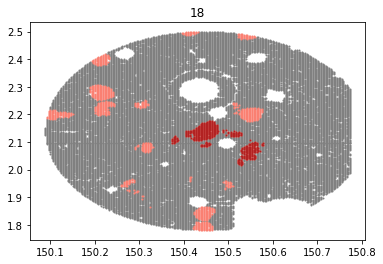

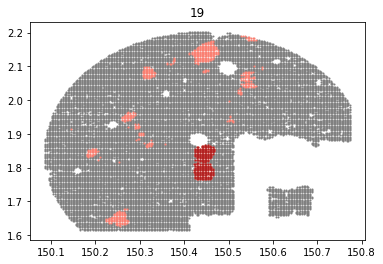

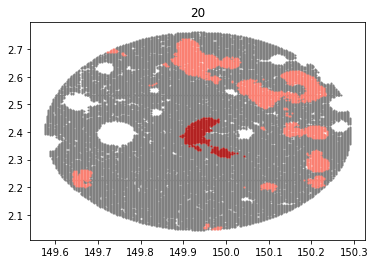

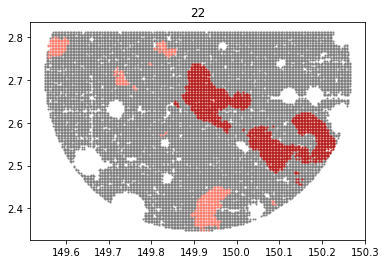

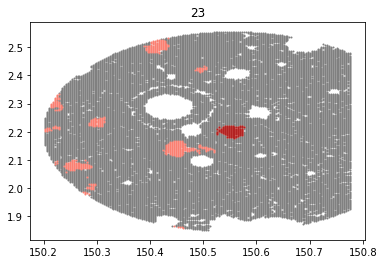

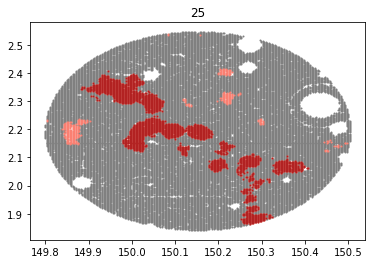

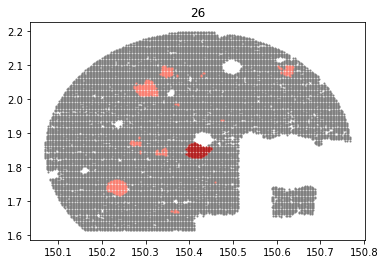

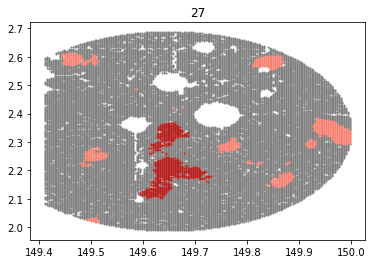

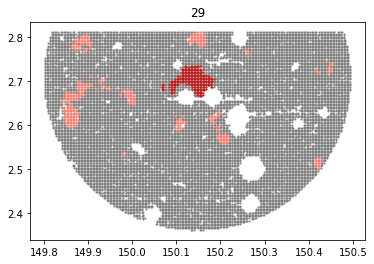

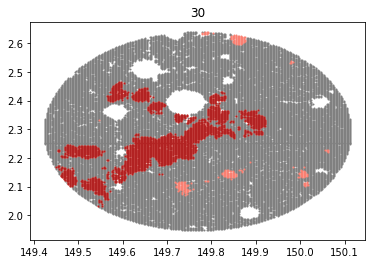

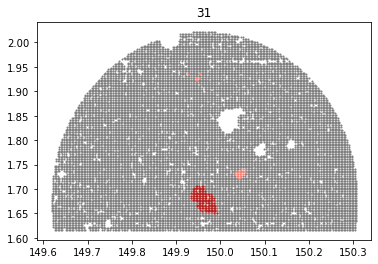

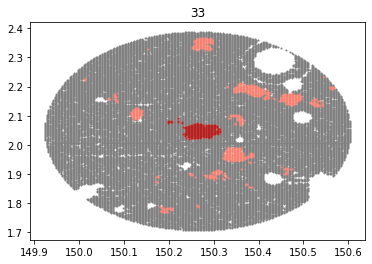

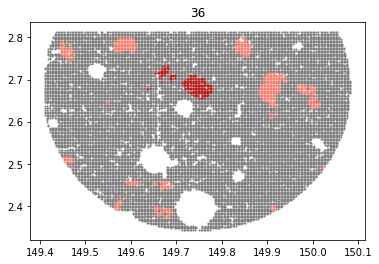

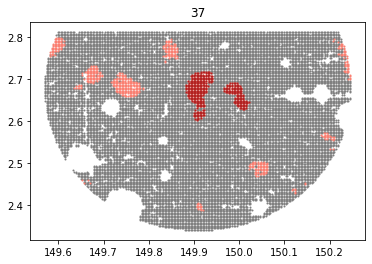

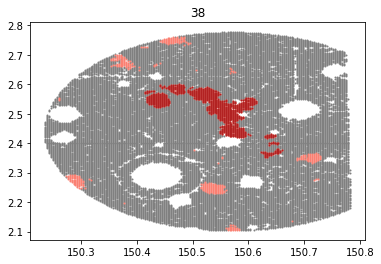

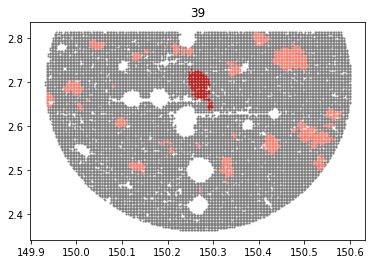

In [112]:
fofs2 = cal_fofs(cands2)
fqs2 = cal_fqs(cands2)

-0.2078169479917589


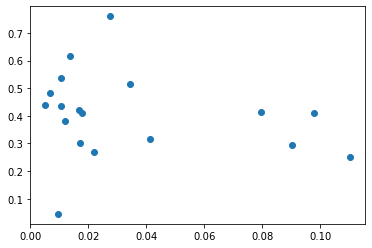

In [113]:
plt.scatter(fofs2, fqs2)
print(np.corrcoef(fofs2, fqs2)[0, 1])

In [114]:
len(fqs2), len(fofs2)

(18, 18)

In [115]:
fqs[0], fofs[0]

(0.6136363636363636, 0.027675345476217084)

In [ ]:
pl